# Extracting enriched function modules from a given study

We have checked that for this particular condition our analysis seems to be really consistent and not affected by the cutoff value of the GIMME method. But for extracting new insights and patterns from a whole study we need to apply this method across all experimental conditions tested.

In [18]:
import os
import cobra
from cobra.flux_analysis import flux_variability_analysis
import reframed
from reframed import load_cbmodel, from_cobrapy
from reframed.cobra.transcriptomics import gene_to_reaction_expression
import gurobipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tools.designFunctions import *
from numpy import percentile
import plotly.express as px
#For constructing the ica object:
from pymodulon.core import IcaData
from pymodulon import example_data
from pymodulon.io import save_to_json, load_json_model

### 1.Load expression data and the GEM

In [2]:
species = 'escherichia_coli'
study_name = 'Omics_Study'
metadata_filepath = '/'.join(['data',species,'sample_table.csv'])
expression_filepath = '/'.join(['data',species,'log_tpm.csv'])
metadata = pd.read_csv(metadata_filepath)
expression_data = pd.read_csv(expression_filepath).set_index('Geneid')
    
#Study_dict has a pattern of:
#            { <media_name>-{<carbon_source.key>:<carbon_source.value>}*nº of sources : <replicate ids list> }
study_dict = { 'm9-EX_glc__D_e:10.0-EX_glu__L_e:8.33': ['ecoli_00050',
                                                       'ecoli_00051'],
                'm9-EX_glc__D_e:10.0-EX_gly_e:3.33': ['ecoli_00052',
                                                    'ecoli_00053'],
                'm9-EX_glc__D_e:10.0-EX_thr__L_e:6.67': ['ecoli_00054',
                                                       'ecoli_00055']
              }

#Load the model
model_name = 'iML1515.xml'
model_filepath = '/'.join(['models', model_name])
cobra_model = cobra.io.read_sbml_model(model_filepath)
cobra_model = reformat_bounds(cobra_model)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-19
Read LP format model from file /tmp/tmpovia7875.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros


In [3]:
#Create directories for saving the results
results_dir = '/'.join(['results', species])
study_results_dir = '/'.join([results_dir, study_name])
figure_results_dir = '/'.join([results_dir, study_name, 'Figures'])
 
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    os.mkdir(study_results_dir)
    os.mkdir(figure_results_dir)

### 2.Construct the ICA object

#### 2.1 Load expression data and the GEM Load iModulon table to translate columns anD rows in M and A tables respectively:

In [4]:
im_table_filepath = '/'.join(['data',species,'iM_table.csv'])
im_table = pd.read_csv(im_table_filepath)
im_dict = {str(row.k) : row.name for row in im_table[['k','name']].itertuples() }
im_table.set_index('name', inplace=True)
im_table

,k,regulator_readable,function,category,n_genes,exp_var,precision,recall,category_num
name,,,,,,,,,
e14 Removal,0,NaN,NaN,Prophage,13,0.003487,NaN,NaN,21
SG_yzfA,1,NaN,NaN,Unknown,3,0.000530,NaN,NaN,24
SG_ytiD,2,NaN,NaN,Unknown,1,0.000471,NaN,NaN,24
Membrane-1,3,NaN,NaN,Membrane Homeostasis,81,0.009719,NaN,NaN,11
CysB-1,4,CysB,NaN,Amino Acid Metabolism,31,0.009645,0.225806,0.411765,2
...,...,...,...,...,...,...,...,...,...
SG_ybfQ,213,NaN,NaN,Unknown,4,0.000509,NaN,NaN,24
SG_ynaM,214,NaN,NaN,Unknown,2,0.002158,NaN,NaN,24
GlpR-2,215,GlpR,NaN,Carbon Metabolism,6,0.000723,0.833333,0.555556,0


#### 2.2 Construct the basic ICA object

In [5]:
M_table_filepath = '/'.join(['data',species,'M.csv'])
M = pd.read_csv(M_table_filepath)
im_dict['Unnamed: 0'] = 'gen'
M.rename(columns =im_dict, inplace = True)
M.set_index('gen', inplace=True)
M

,e14 Removal,SG_yzfA,SG_ytiD,Membrane-1,CysB-1,CueR/CusR/HprR,DLP12,SG_yqhI,SG_icdC,NQ-ALE3,...,SG_cspH,SG_ymcE,OmpR,NarL,NtrC+RpoS,SG_ybfQ,SG_ynaM,GlpR-2,PdeL,SG_sgrT
gen,,,,,,,,,,,,,,,,,,,,,
b0002,-0.000358,-0.008590,0.003601,-0.012687,0.005562,-0.008805,0.001628,-0.002981,-0.005618,0.002741,...,0.007893,0.007961,0.006694,-0.007216,-0.012779,0.009632,0.000493,0.000036,-0.021155,-0.011153
b0003,-0.010837,0.001999,0.011521,0.002356,0.005713,-0.004448,-0.006117,0.014313,0.006507,-0.001974,...,-0.011125,-0.002493,0.020232,0.015658,-0.004292,0.004611,0.017251,-0.008580,0.008200,-0.001142
b0004,-0.011196,0.010332,0.010215,0.008323,0.002182,-0.004335,-0.001893,0.002386,0.008030,0.002420,...,-0.006413,-0.000588,0.015639,0.012891,-0.000049,0.008568,0.012664,-0.007649,0.014636,-0.008665
b0005,0.001831,0.008297,-0.006886,0.008113,-0.000454,0.004255,0.031781,-0.000679,0.005952,0.011142,...,-0.011150,0.009998,-0.003796,0.023029,-0.008983,-0.002186,-0.008396,-0.003082,0.001796,-0.007888
b0006,0.009458,-0.002019,0.015016,-0.005517,-0.004051,-0.000016,0.002706,0.005039,0.007791,-0.008338,...,-0.002731,0.002148,0.010465,0.007808,0.002363,0.007910,-0.000523,0.002802,0.011354,-0.002649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4399,-0.005435,-0.000862,-0.001009,0.002962,-0.002097,-0.003631,-0.000578,0.000235,-0.002511,0.005352,...,-0.014640,0.005406,-0.005309,-0.007466,-0.002523,0.007945,-0.000425,0.003699,0.014430,-0.001713
b4400,-0.003509,0.007552,0.014341,-0.006045,-0.000268,0.000341,0.010566,0.012339,0.003326,0.023681,...,0.007242,0.026212,-0.010677,0.011861,-0.010043,-0.011006,-0.009490,-0.011233,0.020347,0.005650
b4401,-0.003444,0.007116,0.001074,0.004715,-0.012893,0.000782,-0.012861,-0.021927,-0.010887,0.001683,...,0.002610,-0.003137,0.000657,0.005381,0.028456,0.000641,-0.005313,0.012298,-0.006008,0.011715


In [6]:
A_table_filepath = '/'.join(['data',species,'A.csv'])
A = pd.read_csv(A_table_filepath)
A.rename(columns = {'Unnamed: 0':'iModulon'}, inplace = True)
A.iModulon = [im_dict[str(k)] for k in A.iModulon.values.tolist()]
A.set_index('iModulon', inplace=True)
ica_data = IcaData(M,A)
A

,ecoli_00001,ecoli_00002,ecoli_00003,ecoli_00004,ecoli_00005,ecoli_00006,ecoli_00007,ecoli_00008,ecoli_00009,ecoli_00010,...,ecoli_00836,ecoli_00837,ecoli_00838,ecoli_00839,ecoli_00840,ecoli_00841,ecoli_00842,ecoli_00843,ecoli_00844,ecoli_00845
e14 Removal,-0.128304,0.128304,-1.531027,-1.963977,-0.303246,-0.062866,-1.375827,-1.600358,-0.164066,-0.281141,...,1.603103,2.218117,2.299468,2.110294,2.100683,2.582940,2.064856,2.209638,1.913363,1.891312
SG_yzfA,-0.152539,0.152539,-2.741850,-1.200373,-1.446482,-1.101239,-1.340625,-0.672756,-0.524996,-0.650100,...,-0.904385,-1.173453,-1.248829,-1.370640,-0.901145,-0.604680,-1.560660,-1.439933,-1.571323,-0.645570
SG_ytiD,0.249185,-0.249185,3.262396,3.948667,0.843348,0.983687,2.730156,2.949588,2.111970,2.283055,...,-0.191715,1.451728,1.210193,1.315993,0.945596,0.988214,0.677923,0.638416,-0.321869,-0.996076
Membrane-1,-0.104403,0.104403,-4.916100,-5.861405,1.058649,1.005977,-3.312421,-3.625048,1.257151,1.107445,...,1.834209,1.838009,3.781963,3.501219,3.430569,3.591516,2.605577,2.886943,2.672993,2.162092
CysB-1,-0.176603,0.176603,3.582368,4.747595,2.041670,1.917720,2.480352,3.153594,2.702293,2.850132,...,1.169348,0.965257,0.153500,0.925511,1.315424,1.119001,1.928577,1.671033,1.921350,2.005877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SG_ybfQ,0.252765,-0.252765,-3.197852,-2.348775,-0.730892,0.209796,-2.265536,-1.327736,-2.047324,-1.620692,...,1.366825,1.086655,1.157643,1.151417,1.255827,1.365737,-0.032266,0.540555,0.564042,-0.508422
SG_ynaM,-0.806208,0.806208,-0.236285,2.470518,0.704412,-0.083709,1.204765,3.597766,0.690591,0.239457,...,-1.526969,-0.986787,-1.227507,-0.962135,-1.672937,-0.478441,-0.606239,-0.584500,-1.894849,-1.291428
GlpR-2,-0.374599,0.374599,0.113874,0.020002,-0.130984,-0.361774,0.007051,0.211294,-0.772821,-0.533565,...,0.148360,0.389226,0.229326,0.535328,0.259583,0.249629,0.183686,0.040469,0.177319,0.372662
PdeL,0.095403,-0.095403,-0.208565,-0.049936,0.123347,0.015959,-0.323685,-0.192190,0.406844,1.019091,...,0.245031,0.236841,0.854063,1.107624,1.768854,2.035715,0.893494,1.093992,1.232302,1.613547


#### 2.3 Add the expression matrix, the Annotation and iModulon table to the ICA object to get to all regulatory info (COG, regulators ...)

In [7]:
ica_data.X = expression_data
annotation_table_filepath = '/'.join(['data',species,'gene_info.csv'])
annot_table = pd.read_csv(annotation_table_filepath)
annot_table.rename(columns = {'Unnamed: 0':'gene_id'}, inplace = True)
annot_table.set_index('gene_id', inplace=True)
ica_data.gene_table = annot_table
display(annot_table)
ica_data.imodulon = im_table

,gene_name,synonyms,gene_product,cog,regulator,uniprot,start,end,strand,essential,...,y_ome,k_eff,schmidt_prot_med,heckmann_prot_med,proteomics,p1k,p1k_ctrl_log_tpm,p1k_median_log_tpm,p1k_mad_log_tpm,in_iM
b0002,thrA,thrA;thrA1;thrA2,fused aspartate kinase/homoserine dehydrogenase 1,Amino acid transport and metabolism,"RpoD,Ile-tRNA,Thr-tRNA,DksA,Fnr,ArcA,ppGpp",P00561,337,2799,+,False,...,False,True,4101.5,4434.0,True,True,10.314562,9.605329,1.042143,True
b0003,thrB,thrB,homoserine kinase,Nucleotide transport and metabolism,"RpoD,Ile-tRNA,Thr-tRNA,DksA,ppGpp",P00547,2801,3733,+,False,...,False,True,442.0,1177.0,True,True,9.982251,9.232803,1.035654,True
b0004,thrC,thrC,threonine synthase,Amino acid transport and metabolism,"RpoD,ppGpp,Ile-tRNA,Thr-tRNA,DksA",P00934,3734,5020,+,False,...,False,True,8818.5,3516.0,True,True,9.973666,9.274271,0.906287,True
b0005,yaaX,yaaX,DUF2502 domain-containing protein YaaX,Function unknown,Lrp,P75616,5234,5530,+,False,...,True,False,NaN,NaN,False,True,7.132482,6.283661,1.093146,True
b0006,yaaA,yaaA,peroxide stress resistance protein YaaA,Function unknown,NaN,P0A8I3,5683,6459,-,False,...,True,True,539.5,333.0,True,True,6.494941,6.346626,0.454519,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4747,yneP,NaN,protein YneP,No COG annotation,NaN,UPI000E46657A,1579545,1579667,+,False,...,False,False,NaN,NaN,False,True,0.619141,1.132974,1.574864,True
b4748,ynfT,NaN,Qin prophage%3B protein YnfT,No COG annotation,NaN,UPI000A4EFCBB,1632890,1633003,+,False,...,False,False,NaN,NaN,False,True,0.000000,2.460854,2.636141,True
b4751,yoaL,NaN,protein YoaL,No COG annotation,NaN,UPI000187BD99,1901573,1901782,-,False,...,False,False,NaN,NaN,False,True,5.599442,5.048395,0.801117,True
b4755,yqhI,NaN,protein YqhI,"Secondary metabolites biosynthesis, transport,...",NaN,UPI0001DBD4CA,3147597,3147740,-,False,...,False,False,NaN,NaN,False,True,2.399592,1.185744,1.757983,True


#### 2.4 Add the TRN to the ICA object to enable automated calculation of regulon enrichments

In [8]:
trn_filepath = '/'.join(['data',species,'trn.csv'])
trn = pd.read_csv(trn_filepath)
trn.drop(columns=['Unnamed: 0'], inplace=True)
ica_data.trn = trn
trn

,regulator,gene_name,gene_id,effect,evidence,source
0,AccB,accB,b3255,-,0.0,RegulonDB_TF
1,RpoD,pheP,b0576,+,0.0,RegulonDB_sigma
2,RpoD,pheA,b2599,+,0.0,RegulonDB_sigma
3,RpoD,pgpB,b1278,+,0.0,RegulonDB_sigma
4,RpoD,pgpA,b0418,+,0.0,RegulonDB_sigma
...,...,...,...,...,...,...
10139,XynR,yagA,b0267,NaN,NaN,Ecocyc
10140,XynR,yagE,b0268,NaN,NaN,Ecocyc
10141,XynR,yagB,b0266,NaN,NaN,Ecocyc
10142,XynR,yagF,b0269,NaN,NaN,Ecocyc


### 3.Generate the functional data for each functional class

In [9]:
gene_presence_list_filepath = '/'.join(['data',species,'gene_presence_list.csv'])
gene_presence_list = pd.read_csv(gene_presence_list_filepath)
gene_presence_list.drop(columns=['Unnamed: 0'], inplace=True)
im_dict.pop('Unnamed: 0')
gene_presence_list['iModulon'].replace({int(k):v for k,v in im_dict.items()}, inplace=True)
gene_presence_list

,iModulon,Gene
0,e14 Removal,b1137
1,e14 Removal,b1138
2,e14 Removal,b1139
3,e14 Removal,b1140
4,e14 Removal,b1141
...,...,...
3338,PdeL,b0832
3339,PdeL,b0833
3340,PdeL,b0834
3341,SG_sgrT,b4662


In [10]:
#for the putida and ecoli models we used .mat as the .xml version does not have subsystems
matlab_model = cobra.io.load_matlab_model(model_filepath.replace('.xml','.mat'))
all_genes = ica_data.gene_names
subsystem_dict ={}
for r in matlab_model.reactions:
    if r.subsystem not in subsystem_dict.keys():
        subsystem_dict[r.subsystem] = set()
         
    subsystem_dict[r.subsystem] |= set([g.id for g in r.genes if g.id in all_genes])

subsystem_presence_data = {'Subsystem' : [s for s_s in [[subsystem]*len(subsystem_dict[subsystem]) 
                                                        for subsystem in subsystem_dict.keys()] 
                                          for s in s_s],
                          'Gene' : [g for g_s in [subsystem_dict[subsystem] 
                                                  for subsystem in subsystem_dict.keys()]
                                    for g in g_s]}

subsystem_df = pd.DataFrame.from_dict(subsystem_presence_data)
subsystem_df

,Subsystem,Gene
0,Nucleotide Salvage Pathway,b1098
1,Nucleotide Salvage Pathway,b1009
2,Nucleotide Salvage Pathway,b3590
3,Nucleotide Salvage Pathway,b0469
4,Nucleotide Salvage Pathway,b2146
...,...,...
1680,Murein Biosynthesis,b1113
1681,Murein Biosynthesis,b2519
1682,Murein Biosynthesis,b0632
1683,Metabolite Repair,b1779


### 4.Perform the enrichment analysis for each functional class

In [11]:
#imodulon key goes with the functional class column of interest
imodulon_functional_class = 'category'
functional_data = {'_'.join(['iModulon', imodulon_functional_class]) : gene_presence_list,
                   'Subsystem': subsystem_df }
#We get the functionality for each iModulon, as it represents the same abstaction level that subsystem
#Dict to map imodulons with their functions
imodulon_function = { im : [ f for f in im_table.loc[[im]][imodulon_functional_class].values ] for im in ica_data.imodulon_names }
#Dict to map reactions with their genes
rxn_gene_dict = {rxn.id : [g.id for g in cobra_model.reactions.get_by_id(rxn.id).genes]
                           for rxn in cobra_model.reactions}

In [12]:
sensitivity_result_dict={'Gene': {},
                         'Function':{}}

composition_result_dict={}

cutoff_range = range(1, 20)

for condition in study_dict:
    interest_samples = study_dict[condition]
    gene_exp_replicates = expression_data[interest_samples].to_dict()
    #Preprocess the model with metadata obtained for each condition
    media_name = condition.split('-')[0]
    media = Media(species, media_name)
    carbon_source = {s.split(':')[0] : float(s.split(':')[1]) for s in condition.split('-')[1:]}
    exchange_source = ', '.join(list(carbon_source.keys()))
    media_model = set_medium(cobra_model, media.get_predefined_media_definition(), carbon_source)
    #Save model to a temporal file
    rf_media_model = from_cobrapy(media_model)
    target_biomass = rf_media_model.biomass_reaction
    #Perform sensitivity test
    print('Performing reaction sensitivity test for %s in %s media with %s as carbon source(s)' % (species, media_name, exchange_source))
    reaction_sets = reaction_sensitivity_to_cutoff( cutoff_range, gene_exp_replicates, rf_media_model, carbon_source )
    for reaction_type in reaction_sets:
        print('Performing gene sensitivity test for %s' % reaction_type)
        sensitivity_result_dict['Gene'][condition+'_'+reaction_type] = gene_sensitivity_to_cutoff(reaction_sets[reaction_type], rf_media_model)
        print('Performing function sensitivity test for %s' % reaction_type)
        sensitivity_result_dict['Function'][condition+'_'+reaction_type] = function_sensitivity_to_cutoff(reaction_sets[reaction_type], 
                                                                                             rf_media_model, ica_data, functional_data)

    #Functional composition percentage for reactions always present
    reactions_for_composition_analysis = { r_t : set([r for r_s in reaction_sets[r_t] for r in r_s])
                                           for r_t in reaction_sets}
    
    genes_for_composition_analysis = { r_t : set([g 
                                                  for g_s in [rxn_gene_dict[r] 
                                                              for r in reactions_for_composition_analysis[r_t]]
                                                  for g in g_s])
                                     for r_t in reaction_sets}

    composition_result_dict[condition] = get_functional_class_composition(functional_data, imodulon_function, genes_for_composition_analysis)


Read LP format model from file /tmp/tmpccqhrbds.lp
Reading time = 0.01 seconds
: 1877 rows, 5424 columns, 21150 nonzeros
Performing reaction sensitivity test for escherichia_coli in m9 media with EX_glc__D_e, EX_glu__L_e as carbon source(s)
Applying method for cutoff value of 1
0.013260850020000001
0.002456511
1259 reactions are being expressed according RNAseq but not active according GIMME
239 reactions are being expressed according RNAseq and GIMME
195 reactions are not being expressed according RNAseq but active according GIMME
1019 reactions are not being expressed according RNAseq and GIMME
704 reactions are related with biomass component using EX_glc__D_e, EX_glu__L_e as carbon source(s)
989 reactions are no related with biomass component using EX_glc__D_e, EX_glu__L_e as carbon source(s)
Applying method for cutoff value of 2
0.0223636074
0.009086984900000001
1251 reactions are being expressed according RNAseq but not active according GIMME
241 reactions are being expressed acco

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [704, 703, 709, 701, 713, 707, 707, 703, 701, 699, 696, 685, 679, 678, 679, 671, 670, 669, 669]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment
Computing Curli iModulon_category enrichment
Computing SG_ymdG iModulon_category enrichment
Computing Fnr-1 iModulon_category en

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [694, 713, 694, 698, 697, 691, 696, 692, 695, 692, 690, 691, 692, 689, 691, 691, 687, 692, 685]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment
Computing Curli iModulon_category enrichment
Computing SG_ymdG iModulon_category enri

{'Cutoff': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'Reaction_number': [669, 676, 673, 683, 674, 678, 669, 658, 650, 650, 648, 647, 647, 646, 638, 639, 637, 640, 639]}


Performing gene sensitivity test for NBR
Performing function sensitivity test for NBR
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
'float' object has no attribute 'casefold'
Computing e14 Removal iModulon_category enrichment
Computing SG_yzfA iModulon_category enrichment
Computing SG_ytiD iModulon_category enrichment
Computing Membrane-1 iModulon_category enrichment
Computing CysB-1 iModulon_category enrichment
Computing CueR/CusR/HprR iModulon_category enrichment
Computing DLP12 iModulon_category enrichment
Computing SG_yqhI iModulon_category enrichment
Computing SG_icdC iModulon_category enrichment
Computing NQ-ALE3 iModulon_category enrichment
Computing YieP iModulon_category enrichment
Computing PhoB-1 iModulon_category enrichment
Computing Curli iModulon_category enrichme

### 5.Extract functional modules for each class

#### 5.1 Save presence data and plot it in a barplot across conditions for each functional class

In [17]:
in_every_cutoff = {}
func_dict = {'Function-1' : 'imodulon_function',
             'Function-2' : 'subsystem' }

for result_type in sensitivity_result_dict:
    in_every_cutoff[result_type] = {}
    #create the filename according to the pattern <species>_<study>_enriched_functions.xlsx
    with pd.ExcelWriter('ecoli_carbon_source_enriched_'+result_type+'.xlsx') as writer:
        for condition in sensitivity_result_dict[result_type]:
            sensitivity_data = sensitivity_result_dict[result_type][condition]
            if result_type == 'Gene':
                set_id = '-'.join([condition.replace(':',''),result_type])
                sensitivity_data.to_excel(writer, sheet_name=set_id)
                in_every_cutoff[result_type][set_id] = set(sensitivity_data.loc[sensitivity_data["Presence"]==1.0, result_type].tolist())
            if result_type == 'Function':
                fc_index = 1
                for sensitivity_df in sensitivity_data:
                    display(sensitivity_df)
                    f = result_type+'-'+str(fc_index)
                    set_id = '-'.join([condition.replace(':',''),f])
                    #Plot the function sensitivity analysis:
                    fig = px.bar(sensitivity_df, x="Function", y="Presence")
                    fig.update_layout(title=dict(text='<b>Function presence using different cutoff values for '+condition+'<b>',x=0.5),
                                      xaxis=dict(tickangle=45),
                                      height = 600
                                     )
                    display(fig)
                    fig_name = set_id.replace(f,func_dict[f])+'_presence.png'
                    fig_save_path='/'.join(['results',species,study_name,'Figures',fig_name])
                    fig.write_image(fig_save_path)
                    fc_index += 1                      
                    in_every_cutoff[result_type][set_id] = set(sensitivity_df.loc[sensitivity_df["Presence"]==1.0, result_type].tolist())
                    sensitivity_df.to_excel(writer, sheet_name=set_id)

,Function,Presence
0,Prophage,0.0
1,Unknown,1.0
2,Membrane Homeostasis,1.0
3,Amino Acid Metabolism,1.0
4,Metal Homeostasis,1.0
5,Energy Metabolism,0.0
6,Phosphate Metabolism,1.0
7,Extracellular Structures,1.0
8,Anaerobiosis,0.0
9,Nucleotide Metabolism,0.0


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,Function,Presence
0,Nucleotide Salvage Pathway,1.000000
1,"Tyrosine, Tryptophan, and Phenylalanine Metabo...",0.000000
2,Purine and Pyrimidine Biosynthesis,0.000000
3,Arginine and Proline Metabolism,1.000000
4,Citric Acid Cycle,0.000000
5,Cofactor and Prosthetic Group Biosynthesis,1.000000
6,Pyruvate Metabolism,0.052632
7,Cysteine Metabolism,1.000000
8,Alternate Carbon Metabolism,1.000000
9,Anaplerotic Reactions,0.000000


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,Function,Presence
0,Prophage,0.000000
1,Unknown,1.000000
2,Membrane Homeostasis,1.000000
3,Amino Acid Metabolism,1.000000
4,Metal Homeostasis,1.000000
5,Energy Metabolism,1.000000
6,Phosphate Metabolism,1.000000
7,Extracellular Structures,0.000000
8,Anaerobiosis,1.000000
9,Nucleotide Metabolism,1.000000


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,Function,Presence
0,Nucleotide Salvage Pathway,1.000000
1,"Tyrosine, Tryptophan, and Phenylalanine Metabo...",1.000000
2,Purine and Pyrimidine Biosynthesis,1.000000
3,Arginine and Proline Metabolism,1.000000
4,Citric Acid Cycle,1.000000
5,Cofactor and Prosthetic Group Biosynthesis,1.000000
6,Pyruvate Metabolism,1.000000
7,Cysteine Metabolism,1.000000
8,Alternate Carbon Metabolism,1.000000
9,Anaplerotic Reactions,1.000000


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,Function,Presence
0,Prophage,0.000000
1,Unknown,0.000000
2,Membrane Homeostasis,1.000000
3,Amino Acid Metabolism,1.000000
4,Metal Homeostasis,1.000000
5,Energy Metabolism,1.000000
6,Phosphate Metabolism,1.000000
7,Extracellular Structures,1.000000
8,Anaerobiosis,0.000000
9,Nucleotide Metabolism,0.000000


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,Function,Presence
0,Nucleotide Salvage Pathway,1.000000
1,"Tyrosine, Tryptophan, and Phenylalanine Metabo...",0.000000
2,Purine and Pyrimidine Biosynthesis,0.000000
3,Arginine and Proline Metabolism,1.000000
4,Citric Acid Cycle,0.000000
5,Cofactor and Prosthetic Group Biosynthesis,1.000000
6,Pyruvate Metabolism,1.000000
7,Cysteine Metabolism,1.000000
8,Alternate Carbon Metabolism,1.000000
9,Anaplerotic Reactions,0.000000


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,Function,Presence
0,Prophage,0.000000
1,Unknown,1.000000
2,Membrane Homeostasis,1.000000
3,Amino Acid Metabolism,1.000000
4,Metal Homeostasis,1.000000
5,Energy Metabolism,1.000000
6,Phosphate Metabolism,0.473684
7,Extracellular Structures,0.000000
8,Anaerobiosis,1.000000
9,Nucleotide Metabolism,1.000000


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,Function,Presence
0,Nucleotide Salvage Pathway,1.000000
1,"Tyrosine, Tryptophan, and Phenylalanine Metabo...",1.000000
2,Purine and Pyrimidine Biosynthesis,1.000000
3,Arginine and Proline Metabolism,1.000000
4,Citric Acid Cycle,1.000000
5,Cofactor and Prosthetic Group Biosynthesis,1.000000
6,Pyruvate Metabolism,1.000000
7,Cysteine Metabolism,1.000000
8,Alternate Carbon Metabolism,1.000000
9,Anaplerotic Reactions,1.000000


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,Function,Presence
0,Prophage,0.0
1,Unknown,1.0
2,Membrane Homeostasis,1.0
3,Amino Acid Metabolism,1.0
4,Metal Homeostasis,1.0
5,Energy Metabolism,1.0
6,Phosphate Metabolism,1.0
7,Extracellular Structures,0.0
8,Anaerobiosis,1.0
9,Nucleotide Metabolism,0.0


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,Function,Presence
0,Nucleotide Salvage Pathway,1.000000
1,"Tyrosine, Tryptophan, and Phenylalanine Metabo...",0.000000
2,Purine and Pyrimidine Biosynthesis,0.000000
3,Arginine and Proline Metabolism,1.000000
4,Citric Acid Cycle,0.000000
5,Cofactor and Prosthetic Group Biosynthesis,1.000000
6,Pyruvate Metabolism,1.000000
7,Cysteine Metabolism,1.000000
8,Alternate Carbon Metabolism,1.000000
9,Anaplerotic Reactions,0.000000


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,Function,Presence
0,Prophage,0.000000
1,Unknown,1.000000
2,Membrane Homeostasis,0.000000
3,Amino Acid Metabolism,1.000000
4,Metal Homeostasis,1.000000
5,Energy Metabolism,1.000000
6,Phosphate Metabolism,0.000000
7,Extracellular Structures,0.000000
8,Anaerobiosis,1.000000
9,Nucleotide Metabolism,1.000000


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,Function,Presence
0,Nucleotide Salvage Pathway,1.000000
1,"Tyrosine, Tryptophan, and Phenylalanine Metabo...",1.000000
2,Purine and Pyrimidine Biosynthesis,1.000000
3,Arginine and Proline Metabolism,1.000000
4,Citric Acid Cycle,1.000000
5,Cofactor and Prosthetic Group Biosynthesis,1.000000
6,Pyruvate Metabolism,1.000000
7,Cysteine Metabolism,1.000000
8,Alternate Carbon Metabolism,1.000000
9,Anaplerotic Reactions,1.000000


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



#### 5.2 Construct a Venn diagram to check shared functional modules across conditions for each functional class

Function-1 always present in every cutoff for every condition
{'Carbon Metabolism', 'Nitrogen Metabolism', 'Phosphate Metabolism', 'Metal Homeostasis', 'Amino Acid Metabolism', 'Membrane Homeostasis'}
{'Nucleotide Metabolism', 'Carbon Metabolism', 'Cofactor Metabolism', 'Fatty Acid Metabolism', 'Energy Metabolism', 'Metal Homeostasis', 'Unknown', 'Redox Stress', 'Amino Acid Metabolism', 'Anaerobiosis'}
Function-2 always present in every cutoff for every condition
{'Transport, Outer Membrane Porin', 'Oxidative Phosphorylation', 'Murein Biosynthesis', 'Lipopolysaccharide Biosynthesis / Recycling', 'Cysteine Metabolism', 'Nucleotide Salvage Pathway', 'Cell Envelope Biosynthesis', 'Transport, Inner Membrane', 'Glycine and Serine Metabolism', 'Glycerophospholipid Metabolism', 'Murein Recycling', 'Arginine and Proline Metabolism', 'Alternate Carbon Metabolism', 'Cofactor and Prosthetic Group Biosynthesis'}
{'Biomass and maintenance functions', 'Murein Biosynthesis', 'Threonine and Lysine Met

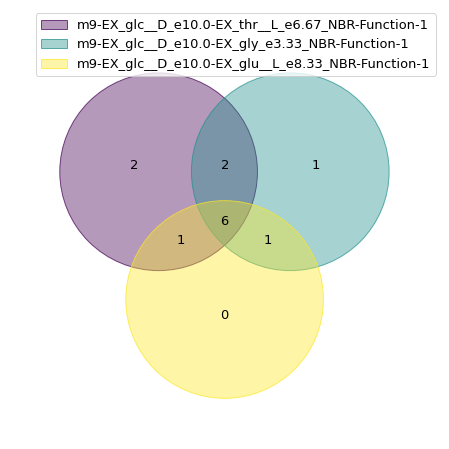

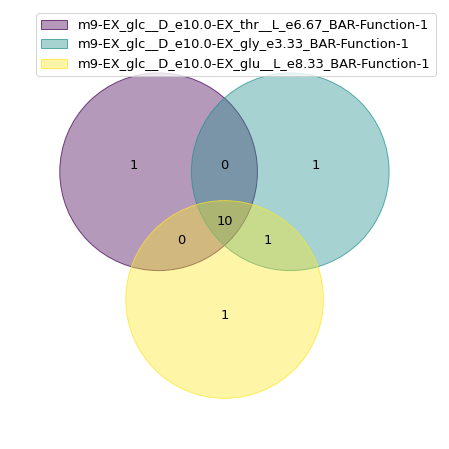

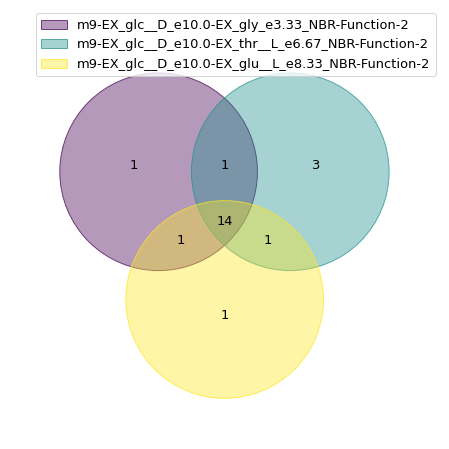

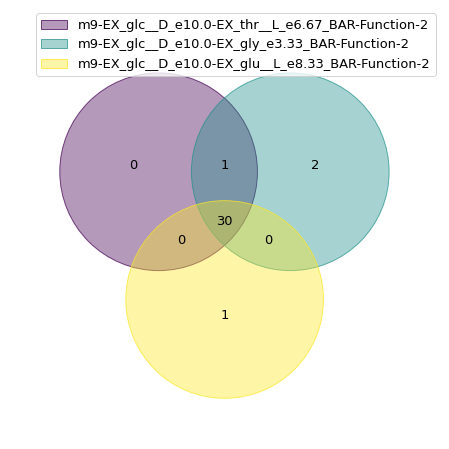

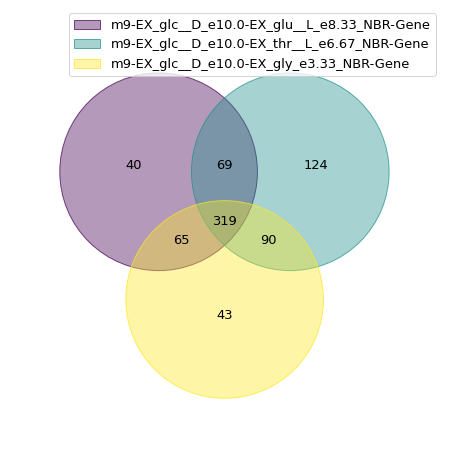

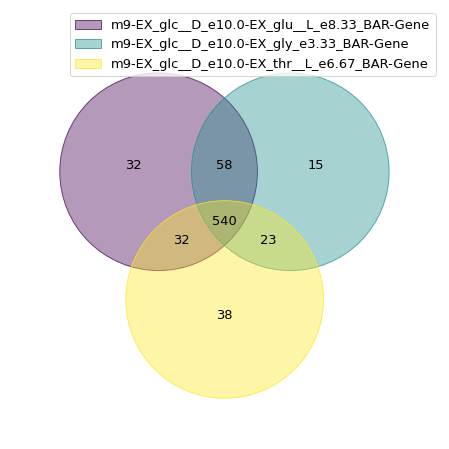

In [21]:
from venn import venn
%matplotlib inline

cathegories = {"Function-1" : "iModulon_function",
               "Function-2" : "Subsystem_function",
               "Gene" : "Gene"
              }
reaction_types = ["NBR", "BAR"]
filterByKeyPattern = lambda cat_dict, pattern: {key: cat_dict[key] for key in cat_dict.keys() if pattern in key}

for cat in cathegories:
    print('%s always present in every cutoff for every condition' % cat)
    cat_dict = in_every_cutoff[cat.split('-')[0]]
    for reaction in reaction_types:
        ReactionData = filterByKeyPattern(cat_dict, reaction)
        if cat == 'Gene':
            target_conditions = set(ReactionData.keys())

        if 'Function' in cat:
            FunctionalData = filterByKeyPattern(cat_dict, cat)
            target_conditions = set(FunctionalData.keys()).intersection(set(ReactionData.keys()))
            
        experimentData = {condition : cat_dict[condition] for condition in target_conditions}
        set_list = list(experimentData.values())
        venn(experimentData)
        fig_name = '_'.join([reaction, cathegories[cat], 'venn_diagram.svg'])
        fig_save_path='/'.join(['results', species, study_name, 'Figures', fig_name])
        plt.savefig(fig_save_path)
        print(set_list[0].intersection(*set_list[1:]))

#### 5.3 Save composition data and plot it across conditions for each functional class

In [22]:
from math import sqrt

#create the filename according to the pattern <species>_<study>_functional_composition.xlsx
with pd.ExcelWriter('ecoli_carbon_source_functional_composition.xlsx') as writer:
    for condition in composition_result_dict:
        for fc in composition_result_dict[condition]:
            plot_df = composition_result_dict[condition][fc]
            display(plot_df)
            set_id = '-'.join([condition.replace(':',''), fc])
            plot_df.to_excel(writer, sheet_name=set_id)
            max_value = max([ plot_df[column].max() for column in plot_df.columns ])

            threshold = percentile( [p for (colname,colval) in plot_df.iteritems() for p in colval.values], 60) 

            plot_df = plot_df.loc[(plot_df >= threshold).any(axis=1)]

            bar_node_trace = go.Scatter(
                x=['BAR_Set_percentage']*len(plot_df), y=plot_df.index,
                mode="markers",
                text=['Percentage: '+ str(c) for c in plot_df.BAR_Set_percentage.tolist()],
                marker=dict(
                    color=px.colors.qualitative.D3[0],
                    size=[2*(1/threshold)*s for s in plot_df.BAR_Set_percentage.tolist()],
                    line_width=2)
            )

            nbr_node_trace = go.Scatter(
                x=['NBR_Set_percentage']*len(plot_df), y=plot_df.index,
                mode="markers",
                text=['Percentage: '+ str(c) for c in plot_df.NBR_Set_percentage.tolist()],
                marker=dict(
                    color=px.colors.qualitative.D3[1],
                    size=[2*(1/threshold)*s for s in plot_df.NBR_Set_percentage.tolist()],
                    line_width=2)
            )

            fig = go.Figure(data=[bar_node_trace, nbr_node_trace],
                         layout=go.Layout(
                            title=dict(text = 'Percentage of '+fc+' functions in BARs & NBRs',
                                       y = 0.95, x = 0.55),
                            titlefont_size=16,
                            showlegend=False,
                            hovermode='closest',
                            height = 1200
                            )
                           )

            fig.show()
            fig_name = set_id+'_composition.svg'
            fig_save_path='/'.join(['results',species,study_name,'Figures',fig_name])
            fig.write_image(fig_save_path)
            

,BAR_Set_percentage,NBR_Set_percentage
iModulon_function,,
Prophage,0.000000,0.000000
Unknown,0.000000,0.000000
Unknown,0.000000,0.000000
Membrane Homeostasis,1.260504,1.030928
Amino Acid Metabolism,2.240896,1.374570
...,...,...
Unknown,0.000000,0.000000
Unknown,0.000000,0.000000
Carbon Metabolism,0.560224,0.171821


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,BAR_Set_percentage,NBR_Set_percentage
Subsystem_function,,
Nucleotide Salvage Pathway,9.803922,7.216495
"Tyrosine, Tryptophan, and Phenylalanine Metabolism",3.081232,0.343643
Purine and Pyrimidine Biosynthesis,3.081232,0.343643
Arginine and Proline Metabolism,2.801120,2.920962
Citric Acid Cycle,2.941176,0.000000
Cofactor and Prosthetic Group Biosynthesis,15.966387,9.278351
Pyruvate Metabolism,2.661064,3.264605
Cysteine Metabolism,2.100840,2.749141
Alternate Carbon Metabolism,9.103641,22.680412


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,BAR_Set_percentage,NBR_Set_percentage
iModulon_function,,
Prophage,0.000000,0.000000
Unknown,0.000000,0.000000
Unknown,0.000000,0.000000
Membrane Homeostasis,1.001431,0.827815
Amino Acid Metabolism,2.288984,1.324503
...,...,...
Unknown,0.000000,0.000000
Unknown,0.000000,0.000000
Carbon Metabolism,0.572246,0.165563


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,BAR_Set_percentage,NBR_Set_percentage
Subsystem_function,,
Nucleotide Salvage Pathway,6.866953,6.456954
"Tyrosine, Tryptophan, and Phenylalanine Metabolism",3.147353,0.331126
Purine and Pyrimidine Biosynthesis,3.147353,0.165563
Arginine and Proline Metabolism,3.147353,2.649007
Citric Acid Cycle,2.861230,0.993377
Cofactor and Prosthetic Group Biosynthesis,16.165951,8.940397
Pyruvate Metabolism,2.718169,3.311258
Cysteine Metabolism,2.145923,2.649007
Alternate Carbon Metabolism,8.583691,23.178808


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,BAR_Set_percentage,NBR_Set_percentage
iModulon_function,,
Prophage,0.000000,0.000000
Unknown,0.000000,0.000000
Unknown,0.000000,0.000000
Membrane Homeostasis,1.251739,1.176471
Amino Acid Metabolism,2.225313,1.029412
...,...,...
Unknown,0.000000,0.000000
Unknown,0.000000,0.000000
Carbon Metabolism,0.695410,0.147059


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



,BAR_Set_percentage,NBR_Set_percentage
Subsystem_function,,
Nucleotide Salvage Pathway,9.457580,6.617647
"Tyrosine, Tryptophan, and Phenylalanine Metabolism",3.059805,0.441176
Purine and Pyrimidine Biosynthesis,3.059805,0.294118
Arginine and Proline Metabolism,2.781641,2.205882
Citric Acid Cycle,2.781641,0.735294
Cofactor and Prosthetic Group Biosynthesis,15.994437,7.058824
Pyruvate Metabolism,2.642559,3.382353
Cysteine Metabolism,2.781641,1.911765
Alternate Carbon Metabolism,9.874826,25.882353


/home/alvaro/miniconda3/envs/e_merlin/lib/python3.10/site-packages/openpyxl/workbook/child.py:99: UserWarning:

Title is more than 31 characters. Some applications may not be able to read the file



#### 5.4 Generate a heatmap to check for gene presence and concurrence

In [27]:
gene_fn = '/'.join(['results', species, study_name, 'ecoli_carbon_source_enriched_Gene.xlsx'])
sheets_dict = pd.read_excel(gene_fn, sheet_name=None)
atp_cycles_computed = False
bar_df_list = []
nbr_df_list = []
atp_df_dict = {}
condition_list = []

for name, sheet in sheets_dict.items():
    condition = '-'.join(name.split('-')[1:-1])[:-4]
    target_df = pd.read_excel(gene_fn, sheet_name=name).drop(columns=['Unnamed: 0'])
    target_df.set_index('Gene', inplace=True)

    if atp_cycles_computed:
        atp_df = target_df.loc[target_df.index.isin(cycle_df.gene_id.tolist())]
        target_df = target_df.loc[~target_df.index.isin(cycle_df.gene_id.tolist())]
        
        if condition not in condition_list:
            if len(atp_df) > 0:
                atp_df_dict[condition] = atp_df        
        
        else:
            if len(atp_df) > 0:
                atp_df_dict[condition] = pd.concat([atp_df_dict[condition], atp_df], axis=0)
        
        for reaction in reaction_types:
            if reaction in name:
                atp_df.rename(columns={"Presence": name.replace('_'+reaction+'-Gene','')+"_Presence"}, inplace=True)

    
    if 'BAR' in name:
        target_df.rename(columns={"Presence": name.replace('_BAR-Gene','')+"_Presence"}, inplace=True)
        bar_df_list.append(target_df)
        
    if 'NBR' in name:
        target_df.rename(columns={"Presence": name.replace('_NBR-Gene','')+"_Presence"}, inplace=True)
        nbr_df_list.append(target_df)
        
    condition_list.append(condition)
    
bar_final_df = pd.concat(bar_df_list, axis=1)
nbr_final_df = pd.concat(nbr_df_list, axis=1)

if atp_cycles_computed:
    atp_final_df = pd.concat([df for df in atp_df_dict.values()], axis=1)

for function in functional_data:
    if function.startswith('Subsystem'):
        ss_df = functional_data[function].loc[functional_data[function]['Gene'].isin(bar_final_df.index)]
    
    if function.startswith('iModulon'):
        im_df = functional_data[function].loc[functional_data[function]['Gene'].isin(bar_final_df.index)]

map_df = pd.DataFrame.from_dict({'Subsystem': ['-'.join([ss for ss in ss_df.loc[ss_df['Gene']==g, 'Subsystem'].values.tolist()])
                                               if len([ss for ss in ss_df.loc[ss_df['Gene']==g, 'Subsystem'].values.tolist()]) > 0
                                               else 'Unassigned'
                                               for g in bar_final_df.index ],
                                 'iModulon': ['-'.join([im for im in im_df.loc[im_df['Gene']==g, 'iModulon'].values.tolist()])
                                                        if len([im for im in im_df.loc[im_df['Gene']==g, 'iModulon'].values.tolist()]) > 0
                                                        else 'Unassigned'
                                                        for g in bar_final_df.index ],
                                 'Gene' : [g  for g in bar_final_df.index ]})

map_df.set_index('Gene', inplace=True)


display(bar_final_df)
display(nbr_final_df)
if atp_cycles_computed:
    display(atp_final_df)
display(map_df)

KeyError: 'iModulon'

In [ ]:
for df in atp_df_dict.values():
    display(df)

In [ ]:
im_list = map_df.iModulon.tolist()
ss_list = map_df.Subsystem.tolist()
lut_im = dict(zip(set(im_list), sns.husl_palette(len(set(im_list)), l=0.5, s=0.8)))
row_colors_im = pd.DataFrame(im_list)[0].map(lut_im)
lut_ss = dict(zip(set(ss_list), sns.husl_palette(len(set(ss_list)), l=0.5, s=0.8)))
row_colors_ss = pd.DataFrame(ss_list)[0].map(lut_ss)

In [ ]:
at_least_one_with_one_nbr_df = nbr_final_df[(nbr_final_df[nbr_final_df.columns]==1.0).any(axis=1)]
g = sns.clustermap(at_least_one_with_one_nbr_df,
                   figsize=(4, 8),
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(-0.1, .4, .03, .4))

g.fig.suptitle("Clustermap of gene presence in NBR set among different conditions", y=1.05)

In [ ]:
at_least_one_with_one_bar_df = bar_final_df[(bar_final_df[bar_final_df.columns]==1.0).any(axis=1)]
g = sns.clustermap(at_least_one_with_one_bar_df,
                   figsize=(4, 8),
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(-0.1, .4, .03, .4))
g.fig.suptitle("Clustermap of gene presence in BAR set among different conditions", y=1.05)

In [ ]:
#HACER LO MISMO PARA LAS DEL ATP
at_least_one_with_one_atp_df = atp_final_df[(atp_final_df[atp_final_df.columns]==1.0).any(axis=1)]
g = sns.clustermap(at_least_one_with_one_atp_df,
                   figsize=(4, 8),
                   dendrogram_ratio=(.1, .2),
                   cbar_pos=(-0.1, .4, .03, .4))
g.fig.suptitle("Clustermap of gene presence in BAR set among different conditions", y=1.05)

#### 5.5 Check if the functional class composition of always present genes is maintained with respect to the previous composion analysis

In [ ]:
#hay que editarlo para que acepte tambien los del atp

In [ ]:
all_with_one_nbr_df = nbr_final_df[(nbr_final_df[nbr_final_df.columns]==1.0).all(axis=1)]
all_with_one_bar_df = bar_final_df[(bar_final_df[bar_final_df.columns]==1.0).all(axis=1)]
genes_for_composition_analysis = {'BAR' : all_with_one_bar_df.index.tolist(),
                                  'NBR' : all_with_one_nbr_df.index.tolist()}

gene_function_composition = get_functional_class_composition(functional_data, imodulon_function, genes_for_composition_analysis)


In [ ]:
with pd.ExcelWriter('functional_composition_of_core_genes.xlsx') as writer:
    for fc in list(gene_function_composition.keys()):
        plot_df = gene_function_composition[fc]
        display(plot_df)
        plot_df.to_excel(writer, sheet_name=fc)
        max_value = max([ plot_df[column].max() for column in plot_df.columns ])

        threshold = percentile( [p for (colname,colval) in plot_df.iteritems() for p in colval.values], 60) 

        plot_df = plot_df.loc[(plot_df >= threshold).any(axis=1)]

        bar_node_trace = go.Scatter(
            x=['BAR_Set_percentage']*len(plot_df), y=plot_df.index,
            mode="markers",
            text=['Percentage: '+ str(c) for c in plot_df.BAR_Set_percentage.tolist()],
            marker=dict(
                color=px.colors.qualitative.D3[0],
                size=[2*(1/threshold)*s for s in plot_df.BAR_Set_percentage.tolist()],
                line_width=2)
            )

        nbr_node_trace = go.Scatter(
            x=['NBR_Set_percentage']*len(plot_df), y=plot_df.index,
            mode="markers",
            text=['Percentage: '+ str(c) for c in plot_df.NBR_Set_percentage.tolist()],
            marker=dict(
                color=px.colors.qualitative.D3[1],
                size=[2*(1/threshold)*s for s in plot_df.NBR_Set_percentage.tolist()],
                line_width=2)
            )

        fig = go.Figure(data=[bar_node_trace, nbr_node_trace],
            layout=go.Layout(
                title=dict(text = 'Percentage of '+fc+' functions in BARs & NBRs',
                           y = 0.95, x = 0.55),
                           titlefont_size=16,
                           showlegend=False,
                           hovermode='closest',
                           height = 1200
                          )
                       )

        fig.show()
        fig_name = '_'.join(['core_genes',fc,'composition.png'])
        fig_save_path='/'.join(['results',species,study_name,'Figures',fig_name])
        fig.write_image(fig_save_path)

In [ ]:
rf_model = from_cobrapy(cobra_model)
functional_class = 'Subsystem'
functional_class_list = functional_data[functional_class][functional_class].unique().tolist()

In [ ]:
query_set = set(all_with_one_nbr_df.index.tolist())
always_present_result = get_enrichment_result(query_set, functional_data, 
                                              rf_model, ica_data, 
                                              functional_class_list, functional_class=functional_class)

display(always_present_result)
always_present_result.to_csv('enrichment_analysis_nbr_core_genes.csv')

In [ ]:
enrichment_result = always_present_result.loc[always_present_result['p-Value']<0.05]

fig_1_col = px.colors.qualitative.D3
fig_2_col = px.colors.qualitative.D3[1:]

p_value_fig = px.bar(enrichment_result, x=functional_class, y='p-Value',
                 height=250, color_discrete_sequence=fig_1_col,
                 opacity = [l for l in enrichment_result.target_lenght.tolist()])


recall_fig = px.bar(enrichment_result, x=functional_class, y='recall',
                 height=250, color_discrete_sequence=fig_2_col,
                 opacity = [l for l in enrichment_result.target_lenght.tolist()])


# For as many traces that exist per Express figure, get the traces from each plot and store them in an array.
# This is essentially breaking down the Express fig into it's traces
figure1_traces = []
figure2_traces = []
for trace in range(len(p_value_fig["data"])):
    figure1_traces.append(p_value_fig["data"][trace])

for trace in range(len(recall_fig["data"])):
    figure2_traces.append(recall_fig["data"][trace])

#Create a 2x1 subplot
this_figure = make_subplots(rows=2, cols=1, vertical_spacing=0.02 )

# Get the Express fig broken down as traces and add the traces to the proper plot within in the subplot
for traces in figure1_traces:
    this_figure.append_trace(traces, row=1, col=1)

for traces in figure2_traces:
    this_figure.append_trace(traces, row=2, col=1)

this_figure.update_xaxes(visible=False, showticklabels=False)
this_figure['layout']['yaxis'].update(title='p Value')
this_figure['layout']['yaxis2'].update(title=functional_class+' recall')
this_figure['layout']['xaxis2'].update(title=functional_class, visible=True, showticklabels=True, tickangle=45)

this_figure.update_layout(
        title=dict(
            text='<b>'+functional_class+' enrichment analysis of NBR core genes</b>',
            x=0.5,
            y=0.95,
            font=dict(
                family="Arial",
                size=20,
                color='#000000'
            )
        )
    )


this_figure.update_layout(height=600, font=dict(size=10))
this_figure.show()

In [ ]:
#habría que repetirlo para las BAR
query_set = set(all_with_one_bar_df.index.tolist())
functional_class = 'Subsystem'
functional_class_list = functional_data[functional_class][functional_class].unique().tolist()
always_present_result = get_enrichment_result(query_set, functional_data, 
                                              rf_model, ica_data, 
                                              functional_class_list, functional_class=functional_class)

display(always_present_result)
always_present_result.to_csv('enrichment_analysis_bar_core_genes.csv')

In [ ]:
enrichment_result = always_present_result.loc[always_present_result['p-Value']<0.05]

fig_1_col = px.colors.qualitative.D3
fig_2_col = px.colors.qualitative.D3[1:]

p_value_fig = px.bar(enrichment_result, x=functional_class, y='p-Value',
                 height=250, color_discrete_sequence=fig_1_col,
                 opacity = [l for l in enrichment_result.target_lenght.tolist()])


recall_fig = px.bar(enrichment_result, x=functional_class, y='recall',
                 height=250, color_discrete_sequence=fig_2_col,
                 opacity = [l for l in enrichment_result.target_lenght.tolist()])


# For as many traces that exist per Express figure, get the traces from each plot and store them in an array.
# This is essentially breaking down the Express fig into it's traces
figure1_traces = []
figure2_traces = []
for trace in range(len(p_value_fig["data"])):
    figure1_traces.append(p_value_fig["data"][trace])

for trace in range(len(recall_fig["data"])):
    figure2_traces.append(recall_fig["data"][trace])

#Create a 2x1 subplot
this_figure = make_subplots(rows=2, cols=1, vertical_spacing=0.02 )

# Get the Express fig broken down as traces and add the traces to the proper plot within in the subplot
for traces in figure1_traces:
    this_figure.append_trace(traces, row=1, col=1)

for traces in figure2_traces:
    this_figure.append_trace(traces, row=2, col=1)

this_figure.update_xaxes(visible=False, showticklabels=False)
this_figure['layout']['yaxis'].update(title='p Value')
this_figure['layout']['yaxis2'].update(title=functional_class+' recall')
this_figure['layout']['xaxis2'].update(title=functional_class, visible=True, showticklabels=True, tickangle=45)

this_figure.update_layout(
        title=dict(
            text='<b>'+functional_class+' enrichment analysis of BAR core genes</b>',
            x=0.5,
            y=0.95,
            font=dict(
                family="Arial",
                size=20,
                color='#000000'
            )
        )
    )


this_figure.update_layout(height=600, font=dict(size=10))
this_figure.show()

In [ ]:
#AHORA REPETIMOS EL ANÁLISIS DE ENRIQUECIMIENTO PERO POR CONDICION
#PRIMERO CON NBR
threshold = 0.8
with pd.ExcelWriter('NBR_condition-specific_enrichment_analysis.xlsx') as writer:
    for condition in at_least_one_with_one_nbr_df.columns:
        print('Performing enrichment analysis with %s condition gene set' % condition)
        condition_filtered_df = at_least_one_with_one_nbr_df.loc[at_least_one_with_one_nbr_df[condition]>=threshold]

        query_set = set(condition_filtered_df.index.tolist())
        functional_class = 'Subsystem'
        functional_class_list = functional_data[functional_class][functional_class].unique().tolist()
        always_present_result = get_enrichment_result(query_set, functional_data, 
                                                      rf_model, ica_data, 
                                                      functional_class_list, functional_class=functional_class)

        display(always_present_result)
        always_present_result.to_excel(writer, sheet_name=condition)

In [ ]:
#AHORA REPETIMOS EL ANÁLISIS DE ENRIQUECIMIENTO PERO POR CONDICION
#AHORA CON LOS BAR
threshold = 0.8
with pd.ExcelWriter('BAR_condition-specific_enrichment_analysis.xlsx') as writer:
    for condition in at_least_one_with_one_bar_df.columns:
        print('Performing enrichment analysis with %s condition gene set' % condition)
        condition_filtered_df = at_least_one_with_one_bar_df.loc[at_least_one_with_one_bar_df[condition]>=threshold]

        query_set = set(condition_filtered_df.index.tolist())
        functional_class = 'Subsystem'
        functional_class_list = functional_data[functional_class][functional_class].unique().tolist()
        always_present_result = get_enrichment_result(query_set, functional_data, 
                                                      rf_model, ica_data, 
                                                      functional_class_list, functional_class=functional_class)

        display(always_present_result)
        always_present_result.to_excel(writer, sheet_name=condition) 

In [ ]:
#AHORA REPETIMOS EL ANÁLISIS DE ENRIQUECIMIENTO PERO POR CONDICION
#AHORA CON LOS ATP
threshold = 0.8
with pd.ExcelWriter('ATP_condition-specific_enrichment_analysis.xlsx') as writer:
    for condition in at_least_one_with_one_atp_df.columns:
        print('Performing enrichment analysis with %s condition gene set' % condition)
        condition_filtered_df = at_least_one_with_one_atp_df.loc[at_least_one_with_one_atp_df[condition]>=threshold]

        query_set = set(condition_filtered_df.index.tolist())
        functional_class = 'Subsystem'
        functional_class_list = functional_data[functional_class][functional_class].unique().tolist()
        always_present_result = get_enrichment_result(query_set, functional_data, 
                                                      rf_model, ica_data, 
                                                      functional_class_list, functional_class=functional_class)

        display(always_present_result)
        always_present_result.to_excel(writer, sheet_name=condition) 

### 6.Locate Robustness Cycles in sets and functions

In [ ]:
cycle_df = pd.read_csv('/'.join(['data',species,'robustness_cycles.csv']))
display(cycle_df)

In [ ]:
def get_robustness_cycles_active_reactions(cycle_df, query_set, model):
    result = {c : [] for c in cycle_df.cycle.unique()}

    for rx in cycle_df.reaction_id.unique():
        rx_df = cycle_df.loc[cycle_df.reaction_id == rx]
        rx_genes =  rx_df['gene_id'].tolist()
        cycle = rx_df['cycle'].tolist()[0]
        gpr_string = model.reactions.get_by_id(rx).gpr.to_string()
        if (all([g in query_set for g in rx_genes])) or (any([g in query_set for g in rx_genes]) and 'and' not in gpr_string):
            print('%s reaction of %s is active in this set!' % (rx, cycle))
            result[cycle].append(rx)

        elif any([g in query_set for g in rx_genes]) and 'and' in gpr_string:
            print('some genes of the %s reaction, belonging to %s are present, but not all' % (rx, cycle))
            print(rx_genes)
            print(set(rx_genes).intersection(query_set))
            display()

    return { k : v for k, v in result.items() if v != []}
    

In [ ]:
nbr_set = set(all_with_one_nbr_df.index.tolist())
bar_set = set(all_with_one_bar_df.index.tolist())
print('Analysis for NBR set :')
rx_cycle_nbr = get_robustness_cycles_active_reactions(cycle_df, nbr_set, cobra_model)
print('')
print('Analysis for BAR set :')
rx_cycle_bar = get_robustness_cycles_active_reactions(cycle_df, bar_set, cobra_model)